In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

Функция визуализации качества работы модели:

https://www.kaggle.com/competitions/real-estate-price-prediction-moscow/
Ваша задача этом соревновании - предсказать цены на квартиры в датасете test.csv. Вам будут даны два датасета: train.csv (содержит признаки и цены на квартиры) и test.csv (только признаки).

In [3]:
uri = r"C:/Users/tyunussov/Downloads/train.csv"
src = pd.read_csv(uri)

In [4]:
src.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Предсказать надо **Price**.

### Обзор

Сразу бросается в глаза количество пробелов в LifeSquare и Healthcare_1. Кроме того, надо будет преобразовать признаки типа object или (возможно) отказаться от них.

In [5]:
print(f"{src['Ecology_2'].value_counts()}\n")
print(f"{src['Ecology_3'].value_counts()}\n")
print(f"{src['Shops_2'].value_counts()}")

B    9903
A      97
Name: Ecology_2, dtype: int64

B    9725
A     275
Name: Ecology_3, dtype: int64

B    9175
A     825
Name: Shops_2, dtype: int64


Из-за несбалансированности этих признаков, их можно удалить:

In [6]:
src.drop(["Ecology_2", "Ecology_3", "Shops_2"], axis = 1, inplace = True)

In [7]:
src.sample()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0,177734.553407


### Обработка пропусков и выбросов

#### Признак Id

In [8]:
src["Id"].describe()

count    10000.00000
mean      8383.40770
std       4859.01902
min          0.00000
25%       4169.50000
50%       8394.50000
75%      12592.50000
max      16798.00000
Name: Id, dtype: float64

In [9]:
src["Id"].value_counts()

11809    1
2906     1
5039     1
6213     1
12319    1
        ..
2351     1
13054    1
1512     1
11813    1
7202     1
Name: Id, Length: 10000, dtype: int64

Едва ли одно наблюдение с нулевым id как-то повлияет на работу модели.

#### Признак DistrictId

In [10]:
src["DistrictId"].describe()

count    10000.000000
mean        50.400800
std         43.587592
min          0.000000
25%         20.000000
50%         36.000000
75%         75.000000
max        209.000000
Name: DistrictId, dtype: float64

In [11]:
src.loc[src["DistrictId"] < 1].shape[0]

48

Есть 48 наблюдений с нулевым id, но я думаю нулевой номер района тоже можно считать нормальным.

#### Признак Rooms

In [12]:
src["Rooms"].describe()

count    10000.000000
mean         1.890500
std          0.839512
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

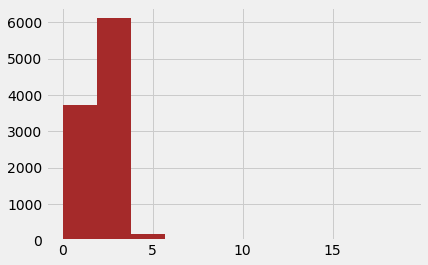

In [13]:
src["Rooms"].hist(fc = 'brown')
plt.show()

Значения больше 6 комнат - явный выброс. Уберем его:

In [14]:
src.loc[src["Rooms"] > 6, "Rooms"] = src["Rooms"].median()

#### Признак KitchenSquare

In [15]:
src["KitchenSquare"].describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

In [16]:
print(f'98 квантиль = {src["KitchenSquare"].quantile(0.98)}')

98 квантиль = 13.0


In [17]:
kitchen_condition = (src["KitchenSquare"] > src["KitchenSquare"].quantile(0.98)) | (src["KitchenSquare"] < 1)
src.loc[kitchen_condition, "KitchenSquare"] = src["KitchenSquare"].median()

#### Признак Square

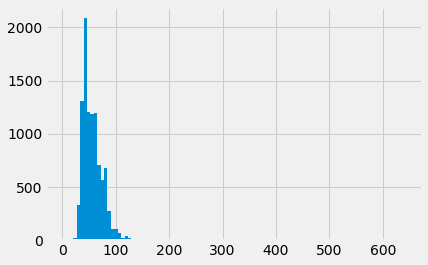

In [18]:
src["Square"].hist(bins = 100)
plt.show()

Проверим квартиры менее 10 кв метров.

In [19]:
src.loc[src["Square"] <= 10].shape[0]

12

Определим границы, за которыми будут выбросы по формуле из источника https://www.youtube.com/watch?v=SaF2G5WMwtg&t=470s

In [20]:
square_q3 = src["Square"].quantile(0.75)
square_q1 = src["Square"].quantile(0.25)
square_interq = square_q3 - square_q1
square_condition = (src["Square"] < square_q1 - square_interq * 1.5) | (src["Square"] > square_q3 + square_interq * 1.5)
print(f"Межквартильный размах, первый и третий квартили: {square_interq, square_q1, square_q3}")
print(f"Медиана, среднее арифметическое: {src['Square'].median(), src['Square'].mean()}")

Межквартильный размах, первый и третий квартили: (24.125744426186976, 41.774880819469836, 65.90062524565681)
Медиана, среднее арифметическое: (52.51330992401352, 56.31577519793557)


In [21]:
src.loc[square_condition, "Square"] = src["Square"].median()

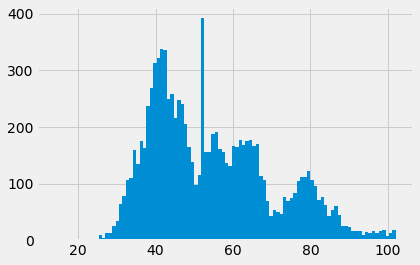

In [22]:
src["Square"].hist(bins = 100)
plt.show()

In [23]:
wrong_square_indexes = src.loc[src["Square"] <= src["LifeSquare"]].index

In [24]:
src.loc[wrong_square_indexes, "LifeSquare"] = src.loc[wrong_square_indexes, "Square"] - src.loc[wrong_square_indexes, "KitchenSquare"]

#### Признак LifeSquare

In [25]:
src["LifeSquare"].describe()

count    7887.000000
mean       34.894929
std        15.184619
min         0.370619
25%        22.761965
50%        32.624585
75%        44.529122
max        99.970065
Name: LifeSquare, dtype: float64

Очевидно, что значение 7480.592129 - это ошибка. Также минимальное значение 0.370619 едва ли может быть похоже на кол-во жилой площади к квартире. Заменим значения меньше 1 кв метра и больше 0.99 перцентиля.

In [26]:
ls_quantile99 = src["LifeSquare"].quantile(0.99)
ls_quantile_condition = (src["LifeSquare"] > ls_quantile99) | (src["LifeSquare"] < 1)

In [27]:
src.loc[ls_quantile_condition, "LifeSquare"] = src["LifeSquare"].median()

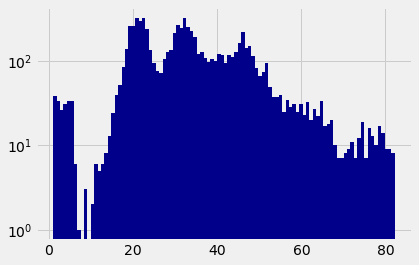

In [28]:
plt.hist(src["LifeSquare"], bins = 100, fc = 'darkblue', log = True)
plt.show()

Возможно значение до 10 кв метров - выбросы, но все же не будем их исключать, поскольку я не уверен в этом.

Теперь заменим неопределенные значения на медиану:

In [29]:
src.loc[src["LifeSquare"].isna() == True, "LifeSquare"] = src["LifeSquare"].median()

In [30]:
src["LifeSquare"].describe()

count    10000.000000
mean        33.983102
std         12.586738
min          1.049867
25%         25.491704
50%         32.624585
75%         40.152612
max         82.237415
Name: LifeSquare, dtype: float64

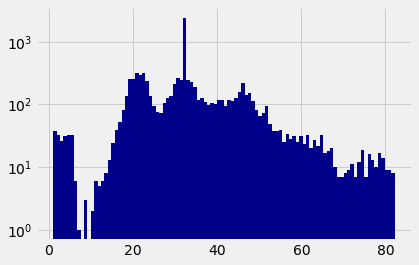

In [31]:
plt.hist(src["LifeSquare"], bins = 100, fc = 'darkblue', log = True)
plt.show()

#### Признак этажности

In [32]:
src["Floor"].describe()

count    10000.000000
mean         8.526700
std          5.241148
min          1.000000
25%          4.000000
50%          7.000000
75%         12.000000
max         42.000000
Name: Floor, dtype: float64

С количеством этажей похоже все в порядке. По данным из сети в Москве есть и 50 этажные дома. Проверим, нет ли противоречий между заявленным этажом квартиры и высотой дома:

In [33]:
src.loc[src["Floor"] > src["HouseFloor"]].shape

(1825, 17)

Есть случаи где этаж больше высоты. Приравняем такие этажи высоте:

In [34]:
wrong_floor_indexes = src.loc[src["Floor"] > src["HouseFloor"]].index
src.loc[wrong_floor_indexes, "Floor"] = src.loc[wrong_floor_indexes, "HouseFloor"]

#### Признак HouseYear

In [35]:
src["HouseYear"] = src["HouseYear"].astype(np.int32)

In [36]:
src["HouseYear"].min(), src.loc[src["HouseYear"] > 2022, "HouseYear"]

(1910,
 8828        4968
 9163    20052011
 Name: HouseYear, dtype: int32)

Видно, что есть явные выбросы сверху, но их всего два, и можно заменить их на медиану:

In [37]:
src.loc[src["HouseYear"] > 2022, "HouseYear"] = src["HouseYear"].median()

#### Признак Healthcare_1

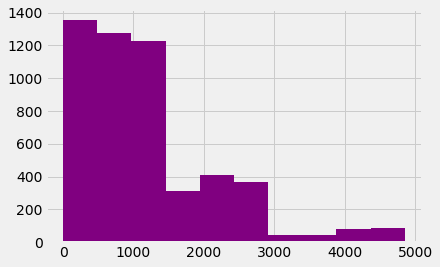

In [38]:
plt.hist(src["Healthcare_1"], bins = 10, fc = 'purple')
plt.show()

Замена пустых значений на медиану или среднюю может исказить реальную картину. Можно попробовать предсказать недостающие значения с помощью модели машинного обучения. Для этого сначала отберем все наблюдения с известным признаком Healthcare_1 в отдельный датафрейм: 

In [39]:
hs1_X = src.loc[src["Healthcare_1"].isna() == False].copy()
hs1_y = src.loc[src["Healthcare_1"].isna() == False, "Healthcare_1"].copy()
hs1_X.drop(["Healthcare_1", "Price"], axis = 1, inplace = True)

Теперь разобьем новый датафрейм на тренировочный и тестовый:

In [40]:
hs1_X_train, hs1_X_test, hs1_y_train, hs1_y_test = train_test_split(hs1_X, hs1_y, test_size=0.3, random_state = 42)

Чтобы минимизировать влияние масштаба данных на результат применим стандартизацию:

In [41]:
hs1_X_train_scaled = scaler.fit_transform(hs1_X_train)
hs1_X_train_scaled = pd.DataFrame(hs1_X_train_scaled, columns = hs1_X_train.columns)

hs1_X_test_scaled = scaler.fit_transform(hs1_X_test)
hs1_X_test_scaled = pd.DataFrame(hs1_X_test_scaled, columns = hs1_X_test.columns)

Теперь применим регрессионную модель RandomForestRegressor и натренируем ее на стандартизированных данных. Я взял эту модель, поскольку нам нужна регрессия, но линейная зависимость или нет, я не знаю.

In [42]:
model = RandomForestRegressor(n_estimators = 1000, max_depth = 12, random_state = 42, n_jobs=-1)
model.fit(hs1_X_train_scaled, hs1_y_train)

RandomForestRegressor(max_depth=12, n_estimators=1000, n_jobs=-1,
                      random_state=42)

Проверим, как модель предскажет значения и оценим качество с помощью метрики R2:

In [43]:
test_prediction = model.predict(hs1_X_test_scaled)
test_prediction

array([1598.48514512, 2250.00360399,  591.721     , ...,  591.721     ,
        295.558     ,  591.721     ])

In [44]:
r2_score(hs1_y_test, test_prediction)

0.9129539703139068

R2 получился довольно высоким. Значит, воспользуемся этой же моделью для предсказания неизвестных значений Healthcare_1.

In [45]:
hs1_na_X = src.loc[src["Healthcare_1"].isna() == True].copy()
hs1_na_X.drop(["Healthcare_1", "Price"], axis = 1, inplace = True)
hs1_na_X

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1
0,11809,27,3.0,52.513310,32.624585,10.0,4,10.0,2014,0.075424,11,3097,0,0,0
3,2352,1,1.0,40.409907,32.624585,1.0,10,22.0,1977,0.007122,1,264,0,0,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,8667,2,0,6
8,9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,1,264,0,0,1
11,16755,88,2.0,53.975144,34.153584,8.0,2,12.0,1978,0.127376,43,8429,3,3,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,9289,1,3.0,84.486078,78.486078,6.0,4,22.0,2016,0.007122,1,264,0,0,1
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,52,10311,6,1,9
9996,16265,27,2.0,64.307684,37.038420,9.0,0,0.0,1977,0.072158,2,629,1,0,0
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,20,4386,14,1,5


In [46]:
hs1_na_X_scaled = scaler.fit_transform(hs1_na_X)
hs1_na_X_scaled = pd.DataFrame(hs1_na_X_scaled, columns = hs1_na_X.columns)

In [47]:
na_prediction = model.predict(hs1_na_X_scaled)
na_prediction

array([ 515.324     ,  916.49062522, 1689.2251034 , ..., 1148.82544969,
       1310.24216667,  929.74370445])

In [48]:
data = src.copy()
hs1_indexes = np.array(hs1_na_X.index)
data.loc[hs1_indexes, "Healthcare_1"] = na_prediction

Проверим заполнение:

In [49]:
data.loc[:, "Healthcare_1"].isna()

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Name: Healthcare_1, Length: 10000, dtype: bool

Функция визуализации качества работы модели:

In [50]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2_score(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2_score(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### Кластеризация с помощью метода Kmeans

Строим график каменистой осыпи, который позволит выявить оптимальное количество кластеров на основе атрибута KMeans.inertia_

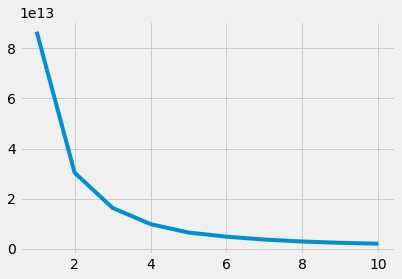

In [51]:
from sklearn.cluster import KMeans
k_list = [x for x in range(1, 11)]
inertias = []
for k in k_list:
    kmeans_model = KMeans(n_clusters = k, random_state = 42)
    kmeans_model.fit(data)
    inertias.append(kmeans_model.inertia_)

plt.plot(k_list, inertias)
plt.show()

Видно, что излом происходит на 2, 3, 4 или 5 кластерах. Попробуем поделить на два кластера. 

In [52]:
k = 2

Функция для визуализации данных:

In [53]:
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

def data_clustering(train_predictors, k_means_labels):
    tsne = TSNE(n_components = 2, learning_rate = 250, random_state = 42)
    X_train_tsne = tsne.fit_transform(train_predictors)
    
    x = X_train_tsne[:, 0]
    y = X_train_tsne[:, 1]
    
    plt.scatter(x, y, c = k_means_labels)
    plt.show()

### Тренировка модели на основе полученных данных
Теперь когда мы почистили датасет, подготовили его, можно приступить к обучению модели на нем.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(data.drop("Price", axis = 1), data["Price"], test_size = 0.3, random_state = 42)

In [55]:
# Попытка стандартизации. Она сильно ухудшает результат.
# X_train_scaled = scaler.fit_transform(X_train)
# X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
# X_test_scaled = scaler.fit_transform(X_test)
# X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)
# X_train_scaled

In [56]:
price_regression = RandomForestRegressor(n_estimators = 1000, max_depth = 15, random_state = 42, n_jobs=-1)
price_regression.fit(X_train, y_train)
train_price_prediction = price_regression.predict(X_train)
price_prediction = price_regression.predict(X_test)

In [57]:
r2_score(y_test, price_prediction)

0.7260822700464116

In [58]:
kmeans_model = KMeans(n_clusters = k, random_state = 42)
kmeans_model.fit(X_train)

KMeans(n_clusters=2, random_state=42)

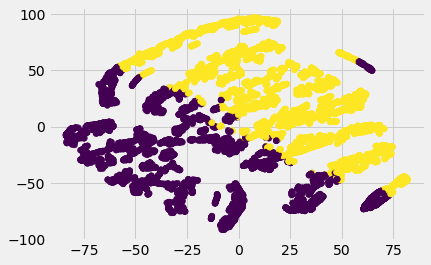

In [59]:
data_clustering(X_train, kmeans_model.labels_)

К сожалению, вряд ли получится выделить здесь кластеры. 

Train R2:	0.942
Test R2:	0.726


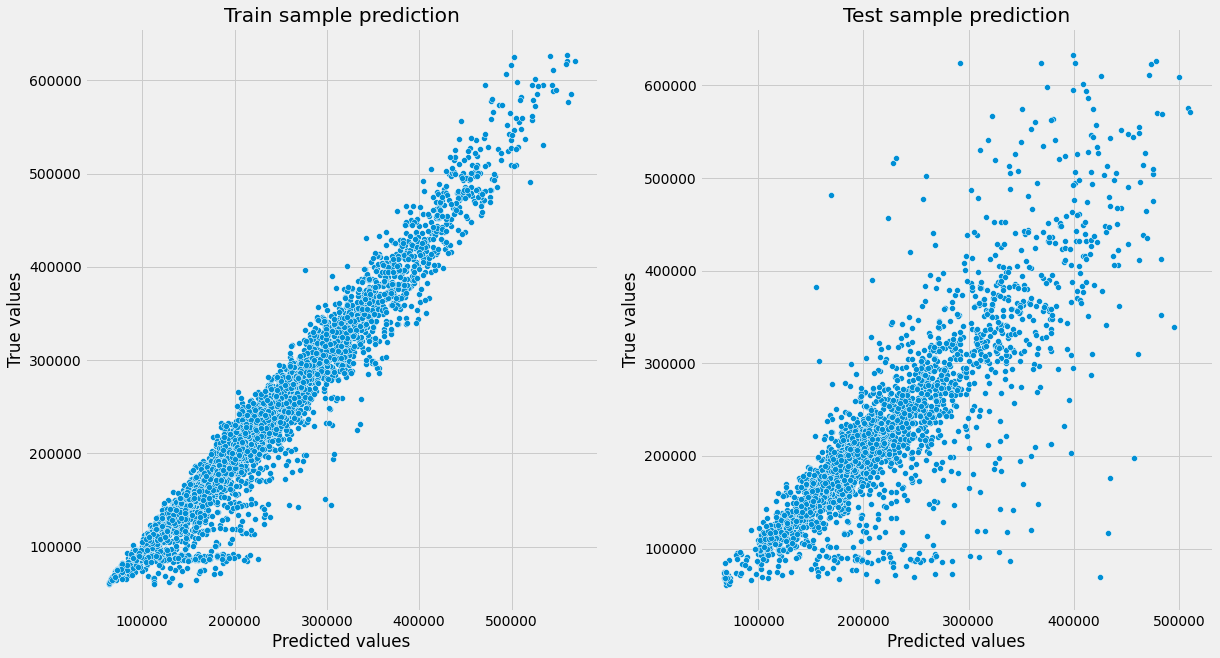

In [60]:
evaluate_preds(y_train, train_price_prediction, y_test, price_prediction)

### Предсказание неизвестных цен
Теперь загрузим датасет с неизвестными ценами:

In [61]:
uri = r"C:/Users/tyunussov/Downloads/test.csv"
test_data = pd.read_csv(uri)

In [62]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [63]:
test_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


Видим, что здесь та же ситуация с признаками LifeSquare и Healthcare_1. Выполним те же преобразования для test датасета, которые мы выполняли на train для создания модели: 

In [64]:
def feature_preprocessing(source_df):
    source_df.drop(["Ecology_2", "Ecology_3", "Shops_2"], axis = 1, inplace = True)
  
    source_df.loc[source_df["Rooms"] > 6, "Rooms"] = source_df["Rooms"].median()

    kitchen_condition = (source_df["KitchenSquare"] > source_df["KitchenSquare"].quantile(0.98)) | (source_df["KitchenSquare"] < 1)
    source_df.loc[kitchen_condition, "KitchenSquare"] = source_df["KitchenSquare"].median()

    square_q3 = source_df["Square"].quantile(0.75)
    square_q1 = source_df["Square"].quantile(0.25)
    square_interq = square_q3 - square_q1
    square_condition = (source_df["Square"] < square_q1 - square_interq * 1.5) | (source_df["Square"] > square_q3 + square_interq * 1.5)
    source_df.loc[square_condition, "Square"] = source_df["Square"].median()

    wrong_square_indexes = source_df.loc[source_df["Square"] <= source_df["LifeSquare"]].index
    source_df.loc[wrong_square_indexes, "LifeSquare"] = source_df.loc[wrong_square_indexes, "Square"] - source_df.loc[wrong_square_indexes, "KitchenSquare"]

    ls_quantile99 = source_df["LifeSquare"].quantile(0.99)
    ls_quantile_condition = (source_df["LifeSquare"] > ls_quantile99) | (source_df["LifeSquare"] < 1)
    source_df.loc[ls_quantile_condition, "LifeSquare"] = source_df["LifeSquare"].median()
    source_df.loc[source_df["LifeSquare"].isna() == True, "LifeSquare"] = source_df["LifeSquare"].median()

    wrong_floor_indexes = source_df.loc[source_df["Floor"] > source_df["HouseFloor"]].index
    source_df.loc[wrong_floor_indexes, "Floor"] = source_df.loc[wrong_floor_indexes, "HouseFloor"]

    source_df["HouseYear"] = source_df["HouseYear"].astype(np.int32)
    source_df.loc[source_df["HouseYear"] > 2022, "HouseYear"] = source_df["HouseYear"].median()

    hs1_X = source_df.loc[source_df["Healthcare_1"].isna() == False].copy()
    hs1_y = source_df.loc[source_df["Healthcare_1"].isna() == False, "Healthcare_1"].copy()
    hs1_X.drop("Healthcare_1", axis = 1, inplace = True)
    hs1_X_train, hs1_X_test, hs1_y_train, hs1_y_test = train_test_split(hs1_X, hs1_y, test_size=0.3, random_state = 42)
    
    hs1_X_train_scaled = scaler.fit_transform(hs1_X_train)
    hs1_X_train_scaled = pd.DataFrame(hs1_X_train_scaled, columns = hs1_X_train.columns)
    hs1_X_test_scaled = scaler.fit_transform(hs1_X_test)
    hs1_X_test_scaled = pd.DataFrame(hs1_X_test_scaled, columns = hs1_X_test.columns)
    
    model = RandomForestRegressor(n_estimators = 1000, max_depth = 12, random_state = 42, n_jobs=-1)
    model.fit(hs1_X_train_scaled, hs1_y_train)
    test_prediction = model.predict(hs1_X_test_scaled)
    print(f"Метрика R2 для предсказания признака Healthcare_1: {r2_score(hs1_y_test, test_prediction)}")
    
    hs1_na_X = source_df.loc[source_df["Healthcare_1"].isna() == True].copy()
    hs1_na_X.drop("Healthcare_1", axis = 1, inplace = True)
    hs1_na_X_scaled = scaler.fit_transform(hs1_na_X)
    hs1_na_X_scaled = pd.DataFrame(hs1_na_X_scaled, columns = hs1_na_X.columns)
    na_prediction = model.predict(hs1_na_X_scaled)
    
    result_df = source_df.copy()
    hs1_indexes = np.array(hs1_na_X.index)
    result_df.loc[hs1_indexes, "Healthcare_1"] = na_prediction
    return result_df

In [65]:
test_dataset_processed = feature_preprocessing(test_data)

Метрика R2 для предсказания признака Healthcare_1: 0.7523716350040852


In [66]:
test_dataset_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     5000 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int32  
 9   Ecology_1      5000 non-null   float64
 10  Social_1       5000 non-null   int64  
 11  Social_2       5000 non-null   int64  
 12  Social_3       5000 non-null   int64  
 13  Healthcare_1   5000 non-null   float64
 14  Helthcare_2    5000 non-null   int64  
 15  Shops_1        5000 non-null   int64  
dtypes: float64(7), int32(1), int64(8)
memory usage: 605.6 KB


In [67]:
test_dataset_processed.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.907000,55.096732,34.160062,5.978400,7.838000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1171.553265,1.31940,4.242800
std,4832.674037,44.179466,0.810976,16.126239,12.647028,3.319298,5.454989,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,834.318793,1.47994,4.777365
min,1.000000,0.000000,0.000000,5.647458,1.181139,1.000000,0.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.928216,25.848859,5.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,620.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.779475,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,990.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,65.394081,40.222689,8.000000,11.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1565.677950,2.00000,6.000000
max,16795.000000,212.000000,6.000000,102.781220,82.012534,13.000000,46.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [68]:
price_prediction = price_regression.predict(test_dataset_processed)

In [69]:
price_prediction_result = pd.concat([test_data["Id"], pd.Series(price_prediction, name = "Price")], axis = 1)

In [70]:
price_prediction_result.to_csv(r"C:/Users/tyunussov/Downloads/TYunussov_predictions.csv", index = None)